# Trabajo práctico - Clasificación de diaros

En este trabajo se entrenará un clasificador con las notas de los diarios previamente tratadas a fin que el mismo logre predecir que diario pudo haber sido el autor de una nota determinada

# 1. Librerias, carga de paquetes y configuración



##1.1. Instalacion de paquetes

In [ ]:
!pip install pattern   # Instalar solo una vez

! pip install -U -q spacy
! python -m spacy download es_core_news_lg
! python -m spacy download es
!pip install bayesian-optimization

## 1.2. Carga de paquetes

In [ ]:
import pandas as pd
import os
import nltk
import re

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import plotly.express as px

from pattern.es import lemma

nltk.download('stopwords')
nltk.download('punkt')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Librerias para graficas
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import TSNE

# Librerias para clasificacion
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from sklearn.metrics import roc_curve,roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
import pickle

## 1.3. Configuración pandas
Se configuran las opciones de visualización

In [ ]:
#Configuracion pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.figsize'] = [12,8]

# 2. Datos

Se realizó un webscrapper para obtener la información de los distintos diarios mediante el uso de RSS.


Aquís es tuvo dos lineas de trabajo:

**1 -** Obtención de titulos y descripción mediante RSS

**2 -** Obtención de la nota completa, aqui se hizo un desarrollo en nodejs utilizando los titulos de de RSS y scrapeando la pagina original. 

Debido a que el scrapeo de las paginas originales generaba un copus mas grande en cantidad de dimensiones y por otro lado la cantidad de registros era mas baja que la obtenida con el scrapper de los titulos, nos decidimos por la opcion 1. Nobstante queriamos mencionar el trabajo realizado.

## 2.1. Acceso a drive y carga de dataframe

In [ ]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

# Se cambia la ubicación del directorio raiz
os.chdir("/content/drive/MyDrive/Test Mining/")  # Ubicación para CDB

Mounted at /content/drive


##2.2. Carga del dataframe

Aquí se carga la opción 1, es decir los titulos y descripciones

In [ ]:
df_clarin=pd.read_csv("./datos_crudos_titulos/clarin.csv",sep='|', on_bad_lines='skip')
df_cronica_rss=pd.read_csv("./datos_crudos_titulos/cronica_rss.csv",sep='|', on_bad_lines='skip')
df_pagina12=pd.read_csv("./datos_crudos_titulos/pagina12.csv",sep='|', on_bad_lines='skip')
df_telam=pd.read_csv("./datos_crudos_titulos/telam_rss.csv",sep='|', on_bad_lines='skip')

# Se unene todos los dataframes de cada diario
df=pd.concat([df_clarin,df_cronica_rss,df_pagina12,df_telam])
print(df.groupby(['topico', 'diario']).count())
print("\nTamaño original:"+str(df.shape))

# Se eliminan duplicados
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
print("Tamaño sin duplicados:"+str(df.shape))

# Se concatena informacion y se eliminan columnas y nulos
df['contenido']=df['titulo']+df['despcripcion']
# df=df[['contenido','topico','diario','fecha']].copy()
df=df[['contenido','diario']].copy()
df.dropna(inplace=True)
print("Tamaño sin nulos:"+str(df.shape))

                   titulo  despcripcion  link  fecha
topico   diario                                     
economia clarin      2592          2551  2592   2592
         cronica     1059           680  1059   1059
         pagina12    7357          7357  7357   7357
         telam       1564          1547  1564   1566

Tamaño original:(12574, 6)
Tamaño sin duplicados:(12574, 7)
Tamaño sin nulos:(12134, 2)


#3. Exploración, tokenizacion y limpieza del texto

**IMPORTANTE**: No avanzamos con la eliminación de los acentos y caracteres especiales debido a que tanto la lemmatizacion como word2vect trabajan con diccionarios en Español, por lo tanto esperan palabras con acentos

##3.1. Tokenizacion
Se observó que tokenizar antes de realizar las stopwords genera mejores resultados. Cuando se inverte el orden de estas acciones muchas stopwords no eran eliminadas siendo que estaban dentro del diccionario. Nuestra conclusion fue que la funcion de Tokenizado es un poco mas inteligente que el simple split() utilizado para remover las stopwords

In [ ]:
df['cont_tokens'] = df['contenido'].apply(lambda x: word_tokenize(x, language='spanish'))

##3.1. Stop words
Es importante eliminar las stopwords antes de remover los acentos para que identifique las palabras. Pero tenemos que tener cuidado de buscar la palabra en minuscula y los espacios que tengan las palabras. 

**Ej** vimos que 'la' no la removia el stopwords porque tenía un espacio es decir 'la '

Esto ultimo se salvo cuando realizamos primero el tokenizado


In [ ]:
import string

stop = set(stopwords.words('spanish'))

print("'más' esta en stopword :"+str('más' in stop))
print("'mas' esta en stopwor :"+str('mas' in stop))
print("\nIMPORTANTE: Aquí se puede ver que la palabra sin acento no es encontrada \n\n")

# Por tal motivo se agregan las stop sin acentos
stop = stop.union(set([sw.translate(str.maketrans('áéíóúü','aeiouu')) for sw in stop])) 
stop.update(string.punctuation) # Agrega signos de puntuacion

def limpieza(texto):
  texto=texto.lower().strip()
  # Se limpian los caracteres especiales
  texto=re.sub(r"[^A-Za-z0-9áéíóúüÁÉÍÓÚÜ]+", "", texto)

  #limpio los numeros sino quedan muchas fechas
  texto=re.sub(r"\d+", "", texto)
  return texto

df['cont_stop']=df['cont_tokens'].map(lambda x:[limpieza(word)for word in x if limpieza(word) not in (stop)])
df['cont_stop'].head()

'más' esta en stopword :True
'mas' esta en stopwor :False

IMPORTANTE: Aquí se puede ver que la palabra sin acento no es encontrada 




0                            [var, intervino, argentinos, quedó, diez, , bien, expulsado, florentín, , tigre, dominaba, bicho, , podía, abrir, marcador, llegó, jugada, puede, cambiar, curso, partido, , mirá, patada, recibió, prediger, dejó, milito, diez, ]
1                                                                                [luna, sangre, , detalles, eclipse, noche, cómo, verlo, mejorel, fenómeno, empieza, domingo, extiende, madrugada, lunes, , explicación, especialistas, opciones, disfrutarlo, ]
2    [confirman, , nuevos, casos, coronavirus, argentina, , contagios, cuadruplicaron, menos, messurge, parte, sanitario, publicó, ministerio, salud, , alza, fuerte, dio, últimos, , días, , , , , reportaron, , muertes, , casi, , , menos, domingo, pasado, ]
3                                                                                                           [bajante, río, paraná, , últimos, , meses, agroindustria, pérdidas, us, , , millonesla, recuperación, nivel, trae, alivio

### 3.1.1. Palabras mas frecuentes

In [ ]:
def get_top_n_words(corpus, n=10):
    cv = CountVectorizer()
    corpus_matrix = cv.fit_transform(corpus)
    print(corpus_matrix.shape)
    corpus_matrix = pd.DataFrame.sparse.from_spmatrix(corpus_matrix, columns=cv.get_feature_names())
    aux = corpus_matrix.sum()
    aux=aux.to_frame('count')
    aux.sort_values(by='count',ascending=False,inplace=True)
    aux=aux.head(n)
    return aux

most_importants = get_top_n_words(df['cont_stop'].map(lambda x:' '.join([word for word in x])), n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

(12134, 23387)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


            count
argentina     810
aos           796
hoy           795
censo         685
gobierno      685
mayo          669
minuto        629
cómo          599
presidente    593
alberto       529


##3.2. Eliminación de palabras particulares

Aca se observan que aún hay palabras incorrectas y/o stopwords 

**Por ejemplo: aos, ao, amp, cómo y los espacios vacios**

Se decide eliminarlas manualmente

In [ ]:
words_eliminar = ['aos','ao','amp','cómo','','do',]

df['cont_clear']=df['cont_stop'].map(lambda x:[word for word in x if word not in (words_eliminar)])


**NOTA**: Observamos que la palabra 'cómo' se encuentra en las stopwords sin acento

Se ejecuta nuevamente la frecuencia de palabras

In [ ]:
most_importants = get_top_n_words(df['cont_clear'].map(lambda x:' '.join([word for word in x])), n=500)
print(most_importants.head(10))
px.bar(most_importants, x=most_importants.index, y='count')

(12134, 23382)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



            count
argentina     810
hoy           795
censo         685
gobierno      685
mayo          669
minuto        629
presidente    593
alberto       529
fernández     527
dos           525


Aquí podemos observar que las palabras fueron eliminadas

### 3.1.2. Visualización con nube de palabras
Se utiliza otro metodo a fin de encontrar palabras a eliminar

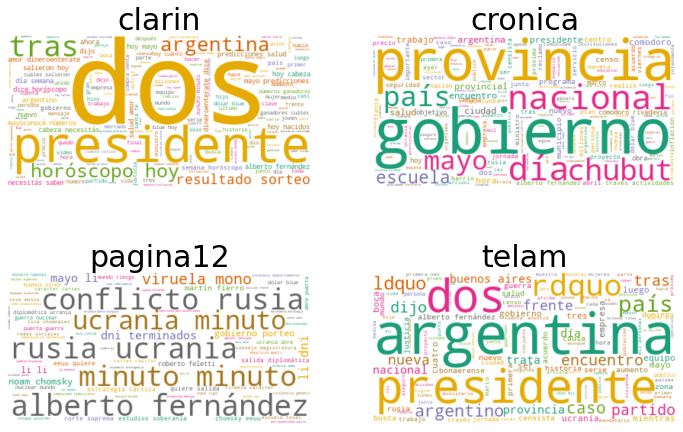

In [ ]:
# plt.rcParams['figure.figsize'] = [16,12]

from wordcloud import WordCloud
wc = WordCloud(stopwords=stop, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


for index,diario in enumerate(df['diario'].unique()):
  texto = " ".join(df[df['diario']==diario]['cont_clear'].map(lambda x:' '.join([word for word in x])))
  wc.generate(texto)
  plt.subplot(2, 2, index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.rcParams['figure.figsize'] = [16, 12]
  plt.axis('off')
  plt.title(diario, fontsize=30)

plt.show()


Ejecutamos nuevamente el script de eliminacion

In [ ]:
words_eliminar2 = ['do','ldquo','rdquo','li']

df['cont_clear']=df['cont_clear'].map(lambda x:[word for word in x if word not in (words_eliminar2)])

## 3.3. Resultados

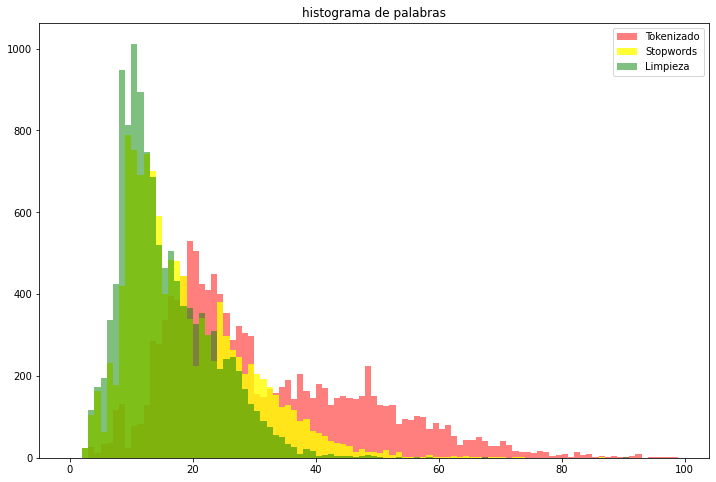

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

plt.hist(df['cont_tokens'].str.len(),bins = np.arange(0,100,1), color='red', alpha=0.5 )
plt.hist(df['cont_stop'].str.len(),bins = np.arange(0,100,1), color='yellow', alpha=0.8 )
plt.hist(df['cont_clear'].str.len(),bins = np.arange(0,100,1), color='green', alpha=0.5 )

plt.title("histograma de palabras")
plt.legend(['Tokenizado','Stopwords','Limpieza'])

**CONCLUSIÓN**: Aqui se puede observar como se va reduciendo la cantidad de palabras en cada registro en funcion del trabajo de limpieza

# 4. Stemming vs Lemmatization
Para la Lemmatization se utilizara el diccionario en español **es_core_news_lg** dado a que es el mas eficiente. En el caso de necesitar mas precisión se puede utilizar **es_dep_news_trf**

https://spacy.io/models


# 4.1. Stemming

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [ ]:
def word_stemmer(text):
    #Luego del stemmer se realiza la remocion de acentos
    stem_text = [PorterStemmer().stem(i).translate(str.maketrans('áéíóúü','aeiouu')) for i in text] 

    return stem_text

df['cont_stemmer'] = df['cont_clear'].map(lambda x: word_stemmer(x))
df['cont_stemmer'].head()


0    [var, intervino, argentino, quedo, diez, bien, expulsado, florentin, tigr, dominaba, bicho, podia, abrir, marcador, llego, jugada, pued, cambiar, curso, partido, mira, patada, recibio, predig, dejo, milito, diez]
1                                                                [luna, sangr, detal, eclips, noch, verlo, mejorel, fenomeno, empieza, domingo, extiend, madrugada, lune, explicacion, especialista, opcion, disfrutarlo]
2    [confirman, nuevo, caso, coronaviru, argentina, contagio, cuadruplicaron, meno, messurg, part, sanitario, publico, ministerio, salud, alza, fuert, dio, ultimo, dia, reportaron, muert, casi, meno, domingo, pasado]
3                                                                                  [bajant, rio, parana, ultimo, mese, agroindustria, perdida, us, millonesla, recuperacion, nivel, trae, alivio, plena, cosecha, gruesa]
4                                                             [asesora, moda, quiso, darl, nuevo, look, bebe, lleno, tatuaj, acu

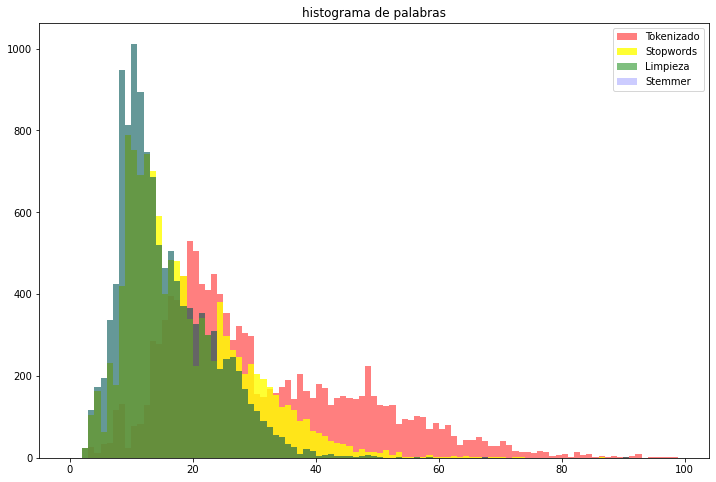

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

plt.hist(df['cont_tokens'].str.len(),bins = np.arange(0,100,1), color='red', alpha=0.5 )
plt.hist(df['cont_stop'].str.len(),bins = np.arange(0,100,1), color='yellow', alpha=0.8 )
plt.hist(df['cont_clear'].str.len(),bins = np.arange(0,100,1), color='green', alpha=0.5 )
plt.hist(df['cont_stemmer'].str.len(),bins = np.arange(0,100,1), color='blue', alpha=0.2 )

plt.title("histograma de palabras")
plt.legend(['Tokenizado','Stopwords','Limpieza','Stemmer'])

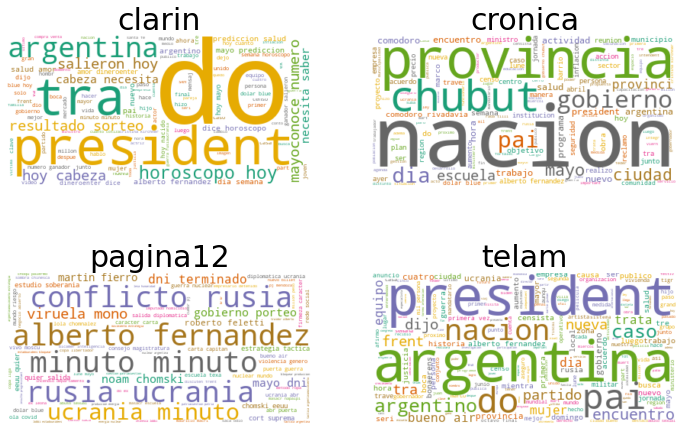

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


for index,diario in enumerate(df['diario'].unique()):
  texto = " ".join(df[df['diario']==diario]['cont_stemmer'].map(lambda x:' '.join([word for word in x])))
  wc.generate(texto)
  plt.subplot(2, 2, index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.rcParams['figure.figsize'] = [16, 12]
  plt.axis('off')
  plt.title(diario, fontsize=30)

plt.show()

##4.2. Lemmatization

In [ ]:
nlp = spacy.load("es_core_news_lg")

def word_lemmatizer(text):
    #Luego de lemmatizar elimino los acentos
    lem_text = [token.lemma_.translate(str.maketrans('áéíóúü','aeiouu')) for token in nlp(" ".join(text))]
    return lem_text

df['cont_lemma'] = df['cont_clear'].apply(lambda x: word_lemmatizer(x))
df['cont_lemma'].head()

0    [var, intervenir, argentino, quedar, diez, bien, expulsado, florentin, tigre, dominar, bicho, poder, abrir, marcador, llegar, jugada, poder, cambiar, curso, partido, mira, patado, recibir, prediger, dejar, milito, diez]
1                                                              [luna, sangre, detalle, eclipse, noche, ver el, mejorel, fenomeno, empezar, domingo, extender, madrugada, lunes, explicacion, especialista, opcion, disfrutar el]
2       [confirmar, nuevo, caso, coronavirus, argentino, contagio, cuadruplicar, menos, messurge, parte, sanitario, publicar, ministerio, salud, alza, fuerte, dar, ultimo, dia, reportar, muerte, casi, menos, domingo, pasado]
3                                                                                        [bajante, rio, parana, ultimo, mes, agroindustrio, perdida, us, millonesla, recuperacion, nivel, traer, alivio, pleno, cosecha, grueso]
4                                                              [asesora, moda, querer, dar el, nuevo

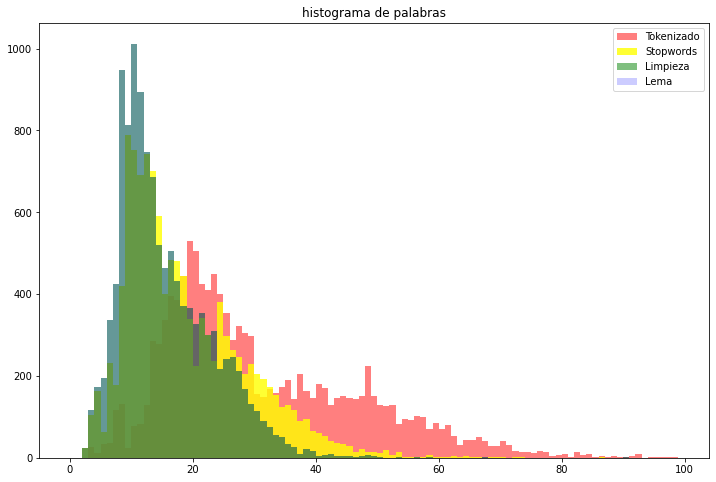

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

plt.hist(df['cont_tokens'].str.len(),bins = np.arange(0,100,1), color='red', alpha=0.5 )
plt.hist(df['cont_stop'].str.len(),bins = np.arange(0,100,1), color='yellow', alpha=0.8 )
plt.hist(df['cont_clear'].str.len(),bins = np.arange(0,100,1), color='green', alpha=0.5 )
plt.hist(df['cont_lemma'].str.len(),bins = np.arange(0,100,1), color='blue', alpha=0.2 )

plt.title("histograma de palabras")
plt.legend(['Tokenizado','Stopwords','Limpieza','Lema'])

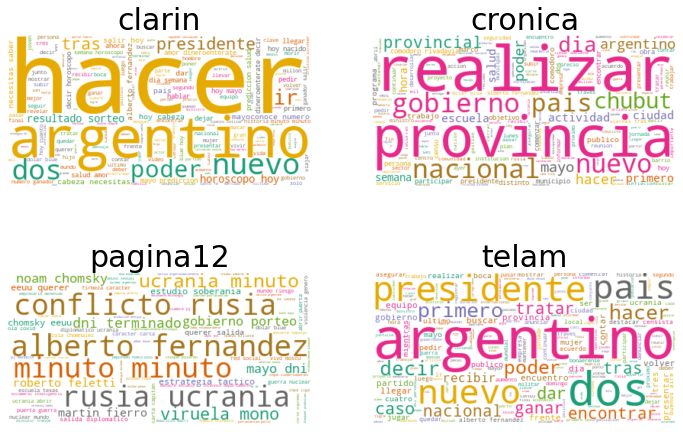

In [ ]:
# plt.rcParams['figure.figsize'] = [16,12]

from wordcloud import WordCloud
wc = WordCloud(stopwords=stop, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


for index,diario in enumerate(df['diario'].unique()):
  texto = " ".join(df[df['diario']==diario]['cont_lemma'].map(lambda x:' '.join([word for word in x])))
  wc.generate(texto)
  plt.subplot(2, 2, index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.rcParams['figure.figsize'] = [16, 12]
  plt.axis('off')
  plt.title(diario, fontsize=30)

plt.show()

#5. **Vectorizacion**


##5.1. TF-IDF para Stemmer

<a id = "1.0"></a>
<p style="font-size:17px;color:#16268a;font-family:'Avantgarde';text-align:left;border-radius:5px;">
Cálculo de frecuencia para la <strong>palabra</strong>:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>feliz</i><BR>
<strong>Cantidad de documentos</strong> por procesar:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;100.000<BR>
<strong>Cantidad total</strong> que aparece "<i>feliz</i>" en <strong>todos los documentos</strong>:&nbsp;&nbsp;&nbsp;&nbsp;1.000<BR>
<strong>Cantidad de palabras</strong> que tienen el <strong>documento evaluado</strong>:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;100<BR>    
<strong>Cantidad total</strong> que aparece "<i>feliz</i>" en el <strong>documento evaluado</strong>:&nbsp;5<BR><BR>   
<strong>TF</strong> es la relación del número total de aparaciones en el documento que se esta evaluando.<BR>    
La frecuencia del termino (<strong>TF</strong>) para "<i>feliz</i>" es entonces (5/100) = 0.05<br><BR>
<strong>IDF</strong>, por otro lado, es una relación de registro del número total de documentos a un documento que contiene una palabra en particular.<br> 
La frecuencia inversa del documento (<strong>IDF</strong>) para "<i>feliz</i>" es entonces log (100.000 / 1.000) = 2<br><BR>
Por lo tanto, el <strong>TF-IDF</strong> para "<i>feliz</i>" en el documento evaluado es: 0.05 * 2 = <strong>0.10</strong>
</p> 

In [ ]:
def tokenization(texts):
  texts_token=word_tokenize(texts, language='spanish')
  lem_text = [token.lemma_ for token in nlp(" ".join(texts_token))]
  
  return lem_text


In [ ]:
tfidf_vectorizer = TfidfVectorizer(analyzer     = "word",
                       decode_error = "ignore",
                      #  encoding     = "str",
                       lowercase    = False,
                      #  stop_words   = stopwords.words("spanish"),
                      #  strip_accents= "ascii",
                       #tokenizer    = lambda texts: [lemma(t) for t in word_tokenize(texts) if (t not in stopwords.words('spanish'))]
                       tokenizer    =lambda texts: texts
                       )

In [ ]:
data=df['cont_stemmer'].values
data_tranform = tfidf_vectorizer.fit_transform(data)
df_stemmer=pd.DataFrame.sparse.from_spmatrix(data_tranform, columns=tfidf_vectorizer.get_feature_names())
print(df_stemmer.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



(12134, 20371)


## 5.2. TF-IDF Lemmatization

In [ ]:
data=df['cont_lemma'].values
data_tranform = tfidf_vectorizer.fit_transform(data)
df_lemma=pd.DataFrame.sparse.from_spmatrix(data_tranform, columns=tfidf_vectorizer.get_feature_names())
print(df_lemma.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



(12134, 17841)


## 5.3 Word2Vect

--------------------------------------------------------------------------------

**IMPORTANTE:** si no se desea realizar todas las operaciones de word2vect dado a que no se tiene el diccionario se puede tomar un atajo de esta seccion ejecutando la siguiente funcion

In [ ]:
#Importa dataset ya verctorizado
# df=pd.read_csv('dataset_enriquecido.csv',sep='|')

 
-------------------------------------------------------------------

In [ ]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

## https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz

# import os
# import gzip

## **IMPORTANTE** Descomentar solo para bajar el archivo
# import requests

# url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz"
# downloaded_obj = requests.get(url)

## Guarda el zip
# with open("cc.es.300.vec.gz", "wb") as file:
#     file.write(downloaded_obj.content)

##Lo descomprime
# with open("cc.es.300.vec", "wb") as file:
#     file.write(contents)

##Elimina el zip
# os.remove("cc.es.300.vec.gz")

In [ ]:
#Se define el objeto que nos permitirá realizar el word to vect
wordvectors_file_vec = 'cc.es.300.vec'

cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

### Filtrado de palabras que no se encuentran en el embeding
Se remueven estas palabras porque cuando se quiere convertir una palabra que no encuentra tira error

In [ ]:
# Diccionario de embeding
dict_esp=list(wordvectors.wv.vocab.keys())

# Se queda solamente 
def check_words(lista):
  rta=[]
  for word in lista:
    if word in (dict_esp):
      rta.append(word)

  return rta

#Me quedo con los tokens que estan en el diccionario del embeding
df['w2v']=df['cont_clear'].map(lambda lista:check_words(lista))

# Genero vectores por palabras
df['vector']=df['w2v'].map(lambda w:wordvectors.wv[w])

# Promedio los vectores
df['embeding_mean']=df['vector'].map(lambda matrix:matrix.mean(axis=0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



**Nota:** Se eligió la opcion de promediar los vectores, otra alternatica es usar redes secuenciales (LSTM) a fin de colapsar varios vectores en uno de ellos

In [ ]:
df.to_csv('dataset_enriquecido.csv',sep='|',index=False)

https://github.com/google-research/bert/blob/master/multilingual.md

https://towardsdatascience.com/bert-text-classification-in-a-different-language-6af54930f9cb

# 6. Clasificador

Se utilizara un LGBM para clasificar los diarios en funcion de las notas. Debido a que es un problema multiclase se entrenara los modelos de un diario contra el resto. 
Se realizara una optimizacion de hiperparametros con busqueda bayesiana

## 6.1. Funciones: busqueda bayesiana, entrenamiento y testeo

### Realiza una busqueda bayesiana para encontrar los hiperparametors optimos

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def metric(y_true,y_pred):
#     y_pred = best_model.predict_proba(X_test)[:, 1]
    res=roc_auc_score(y_true,y_pred)
    return "auc", res, True

# FUNCION DE BUSQUEDA EXTERIOR
def bayes_parameter_opt_lgb(X_train, y_train, init_round=15, opt_round=25, n_folds=3, random_seed=6,output_process=False):
    resultados_globales = []
    train_data = lgb.Dataset(data=X_train, label=y_train,categorical_feature=[], free_raw_data=False)
    
    class_neg=len(y_train['_etiqueta_'])-sum(y_train['_etiqueta_'])
    class_pos=sum(y_train['_etiqueta_'])
    #----------------------- FUNCIÓN DE EVALUACION PARA BUSQUEDA BAYESIANA --------------------------
    def lgb_eval(min_data_in_leaf, num_leaves, min_split_gain,feature_fraction):
        #Seteo de parametros para la BO
        
        train_preds = []
        train_true = []
        # test_preds = pd.DataFrame(np.zeros((X_test.shape[0], 1)), index=X_test.index)
        resultados = {}
    
        params = {}
        params['objective']='binary'
        params["metric"] = 'auc'
        params["num_leaves"] = int(round(num_leaves))
        params["max_depth"]=math.ceil(math.log2(num_leaves*1.8))
        params["learning_rate"]= 0.1
        params["num_iterations"]= int(50 + 5/params["learning_rate"])
        params["early_stopping_rounds"]= round(params["num_iterations"]/10)
        # params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        # params['lambda_l1'] = lambda_l1
        params['min_split_gain'] = min_split_gain # por ahora lo dejo fijo
        params['min_data_in_leaf'] = int(round(min_data_in_leaf)) # por ahora lo dejo fijo
        params['max_bin']= 255 # por ahora lo dejo fijo
#         params['verbose_eval']=True
#         params['seed']=201678
        # params['boosting']='gbdt'
        params['is_unbalace']=True
        params['sample_pos_weight']= class_neg/class_pos # sum(negative instances) / sum(positive instances) 
        params['verbosity']= -100

        params = {}
        params['objective']='binary'
        params["metric"] = 'auc'
        params["learning_rate"]= 0.1
        params["num_iterations"]= int(50 + 5/params["learning_rate"])
        params["early_stopping_rounds"]= round(params["num_iterations"]/10)
        params['is_unbalace']=True
        params['sample_pos_weight']= class_neg/class_pos # sum(negative instances) / sum(positive instances) 
        params['verbosity']= -100
        params['max_bin']= 255
        params['min_split_gain'] = min_split_gain # por ahora lo dejo fijo
        params['min_data_in_leaf'] = int(round(min_data_in_leaf)) # por ahora lo dejo fijo
        params["num_leaves"] = int(round(num_leaves))
        params["max_depth"]=math.ceil(math.log2(num_leaves+1))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        
        resultados = {}
        #------------------------------- EVALUACION CV con FOR -----------------------------
        # model = lgb.LGBMClassifier(**params)
        # kfold = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
        # results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
        # return results.mean()

        kf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
        # kf = KFold(n_splits=3)
        train_preds = []
        train_true = []
        for i, (ti, vi) in enumerate(kf.split(X_train, y_train)):  
            Xt, Xv = X_train.iloc[ti], X_train.iloc[vi]
            yt, yv = y_train.iloc[ti], y_train.iloc[vi]
            model = lgb.LGBMClassifier(**params)
            model.fit(Xt, yt, eval_set=[(Xt, yt), (Xv, yv)],eval_metric=metric,verbose=False)
            preds = pd.Series(model.predict(Xv), index=Xv.index)
            train_preds.append(preds) # Se van agregando las filas de una matriz
            train_true.append(yv)
        
        train_preds = pd.concat(train_preds)
        train_true = pd.concat(train_true)
        resultados["Train"] = roc_auc_score(train_true, train_preds) 
        # Si no se puede traer todos los parametros del modelo se carga el objeto parametro
        try:
            resultados["params"] = model.get_params() 
        except:
            resultados["params"] = params
        resultados_globales.append(resultados)
        pd.DataFrame(resultados_globales).to_csv('BO.csv',index=False)
        # Se envía la métrica como guia para la busqueda bayesiana
        return resultados['Train']
        
    #----------------------- FIN FUNCIÓN DE EVALUACION PARA BUSQUEDA BAYESIANA ------------------------
    
    
    # ESPACIO DE BUSQUEDA 
    lgbBO = BayesianOptimization(lgb_eval, {
                                            # 'lambda_l1':(0, 100),
                                            'min_split_gain':(0.0,0.1),
                                            'min_data_in_leaf': (10, 40),
                                            'num_leaves': (8, 100),
                                            'feature_fraction': (0.1, 1)
                                            }, random_state=random_seed)



    # OPTIMIZADOR
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return pd.DataFrame(resultados_globales)#lgbBO.res

### Entrenamiento: Genera un modelo en el directorio con el nombre que se le asigna

Hay dos funciones de entrenamientouna para TF-IDF y otra para Word2Vect debido a que una de ellas usa matrics sparsa y el procesamiento es diferente

In [ ]:
def entrenamiento(train,nombre):
  categories = list(df['_etiqueta_'].drop_duplicates().values)

  for category in categories:
    # Agregar Train test
    print('Procesando Categoria: {}'.format(category))

    #Se realiza busqueda
    
    # Dataset Train - TODO: Agregar crossvalidation/optimizacion bayesiana
    y_train=(train['_etiqueta_']==category).astype(int).values
    X_train=train.drop(columns=['_etiqueta_']).sparse.to_dense()

    res=bayes_parameter_opt_lgb(X_train, pd.DataFrame(y_train,columns=['_etiqueta_']), init_round=5, opt_round=20, n_folds=3, random_seed=6)
    print("Best AUC is: "+str(res['Train'].max()))
    best_param=res.iloc[res['Train'].argmax()]['params']
    
    # Definicion del modelo
    best_param['early_stopping_rounds']=None
    lgb_c = lgb.LGBMClassifier(**best_param)

    # Entrenar modelo con parametros optimizados
    lgb_c.fit(X_train, y_train)
    pickle.dump(lgb_c, open('modelo_'+category+'_'+nombre+'.pkl', 'wb'))

In [ ]:
def entrenamiento_w2v(train,nombre):
  categories = list(df['_etiqueta_'].drop_duplicates().values)
  for category in categories:
    # Agregar Train test
    print('Procesando Categoria: {}'.format(category))

    #Se realiza busqueda
    
    # Dataset Train - TODO: Agregar crossvalidation/optimizacion bayesiana
    y_train=(train['diario']==category).astype(int).values
    X_train=pd.DataFrame(train['embeding_mean'].to_list())

    res=bayes_parameter_opt_lgb(X_train, pd.DataFrame(y_train,columns=['_etiqueta_']), init_round=5, opt_round=20, n_folds=3, random_seed=6)
    print("Best AUC is: "+str(res['Train'].max()))
    best_param=res.iloc[res['Train'].argmax()]['params']
    
    # Definicion del modelo
    best_param['early_stopping_rounds']=None
    lgb_c = lgb.LGBMClassifier(**best_param)

    # Entrenar modelo con parametros optimizados
    lgb_c.fit(X_train, y_train)
    pickle.dump(lgb_c, open('modelo_w2v_'+category+'_'+nombre+'.pkl', 'wb'))

### Testeo

In [ ]:
def testeo(test,nombre):
  categories = list(df['_etiqueta_'].drop_duplicates().values)
  for category in categories:
    # Agregar Train test
    print('Procesando Categoria: {}'.format(category))
    
    # Dataset Train - TODO: Agregar crossvalidation/optimizacion bayesiana
    # y_train=(train['diario']==category).astype(int).values
    # X_train=train.drop(columns=['diario']).sparse.to_dense()

    # Dataset Test
    y_test=(test['_etiqueta_']==category).astype(int).values
    X_test=test.drop(columns=['_etiqueta_']).sparse.to_dense()

    loaded_model = pickle.load(open('modelo_'+category+'_'+nombre+'.pkl', 'rb'))

    # Busqueda del maximo umbral de corte
    y_pred = loaded_model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)


    ix = argmax(fscore)
    best_thresholds=thresholds[ix]
    if best_thresholds>0.6:
      best_thresholds=0.6
    print("Best thr: "+str(best_thresholds))
    print("AUC:"+str(roc_auc_score(y_test,y_pred)))

    y_pred_binary = np.where(y_pred >= best_thresholds, 1, 0)
    print(classification_report(y_test, y_pred_binary))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Curvas ROC
    # show the plot
    plt.rcParams['figure.figsize'] = (8, 6)

    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
def testeo_w2v(test,nombre):
  categories = list(df['_etiqueta_'].drop_duplicates().values)
  for category in categories:
    # Agregar Train test
    print('Procesando Categoria: {}'.format(category))
    
    # Dataset Train - TODO: Agregar crossvalidation/optimizacion bayesiana
    # y_train=(w2v_train['diario']==category).astype(int).values
    # X_train=pd.DataFrame(w2v_train['embeding_mean'].to_list())

    # Dataset Test
    y_test=(test['_etiqueta_']==category).astype(int).values
    X_test=pd.DataFrame(test['embeding_mean'].to_list())

    loaded_model = pickle.load(open('modelo_w2v_'+category+'_'+nombre+'.pkl', 'rb'))

    # Busqueda del maximo umbral de corte
    y_pred = loaded_model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)


    ix = argmax(fscore)
    best_thresholds=thresholds[ix]
    if best_thresholds>0.6:
      best_thresholds=0.6
    print("Best thr: "+str(best_thresholds))
    print("AUC:"+str(roc_auc_score(y_test,y_pred)))

    y_pred_binary = np.where(y_pred >= best_thresholds, 1, 0)
    print(classification_report(y_test, y_pred_binary))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Curvas ROC
    plt.rcParams['figure.figsize'] = (8, 6)

    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## 6.2. Adecuacion de las matrices (agregado de la etiqueta)

In [ ]:
#se deja la etiqueta del diario en minuscula 
df['_etiqueta_']=df['diario'].map(lambda x:x.lower()) # se deja con guiones bajos para evitar que se duplique con una palabra del corpus

### Stemmer

In [ ]:
#Se agrega etiqueta
df_stemmer=pd.concat([df_stemmer,df[['_etiqueta_']]],axis=1)

# Se quitan filas de todos ceros
# df_stemmer=df_stemmer[df_stemmer.drop(columns=['_etiqueta_']).sum(axis=1)>0]

# Se eliminan nulos
df_stemmer.dropna(inplace=True)
df_stemmer.shape

(11697, 20372)

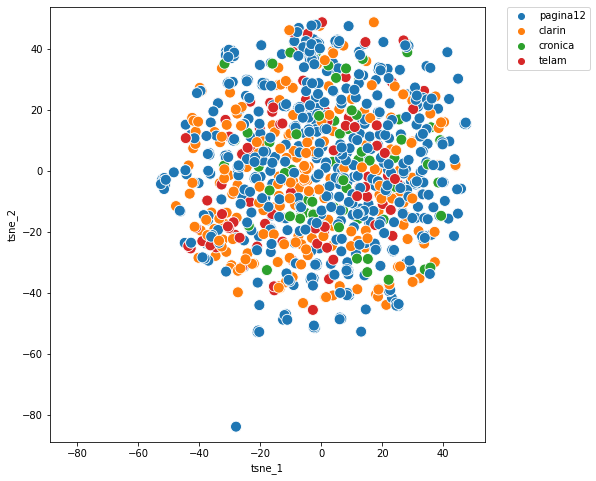

In [ ]:
n_components=2

y=df_stemmer.sample(n=1000,random_state=1978)['_etiqueta_']
X=df_stemmer.sample(n=1000,random_state=1978).drop(columns=['_etiqueta_'])

tsne=TSNE(n_components)
tsne_result=tsne.fit_transform(X)
tsne_result.shape

tsne_result_df=pd.DataFrame({'tsne_1':tsne_result[:,0] ,'tsne_2':tsne_result[:,1] ,'label':y})

# Grafica
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
sns.scatterplot(x='tsne_1',y='tsne_2',hue='label',data=tsne_result_df,ax=ax,s=120)
lim=(tsne_result.min()-5,tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)

### Lemmatization

In [ ]:
#Se agrega etiqueta
df_lemma=pd.concat([df_lemma,df[['_etiqueta_']]],axis=1)

# Se quitan filas de todos ceros
# df_final=df_final[df_final.drop(columns=['_etiqueta_']).sum(axis=1)>0]

# Se eliminan nulos
df_lemma.dropna(inplace=True)

df_lemma.shape

(11697, 17842)

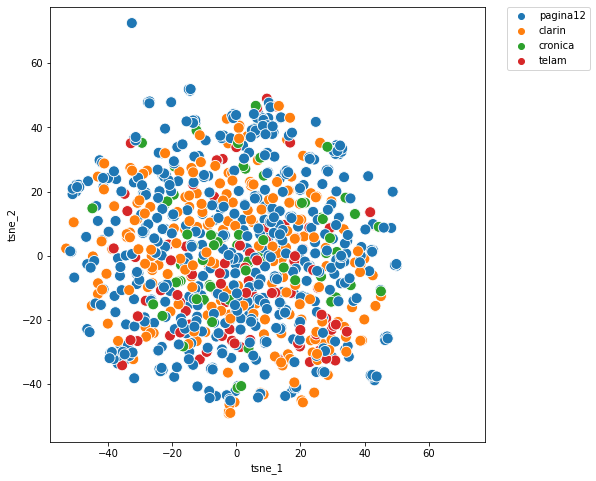

In [ ]:
n_components=2
y=df_lemma.sample(n=1000,random_state=1978)['_etiqueta_']
X=df_lemma.sample(n=1000,random_state=1978).drop(columns=['_etiqueta_'])

tsne=TSNE(n_components)
tsne_result=tsne.fit_transform(X)
tsne_result.shape

tsne_result_df=pd.DataFrame({'tsne_1':tsne_result[:,0] ,'tsne_2':tsne_result[:,1] ,'label':y})

# Grafica
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
sns.scatterplot(x='tsne_1',y='tsne_2',hue='label',data=tsne_result_df,ax=ax,s=120)
lim=(tsne_result.min()-5,tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)

### Word2Vect

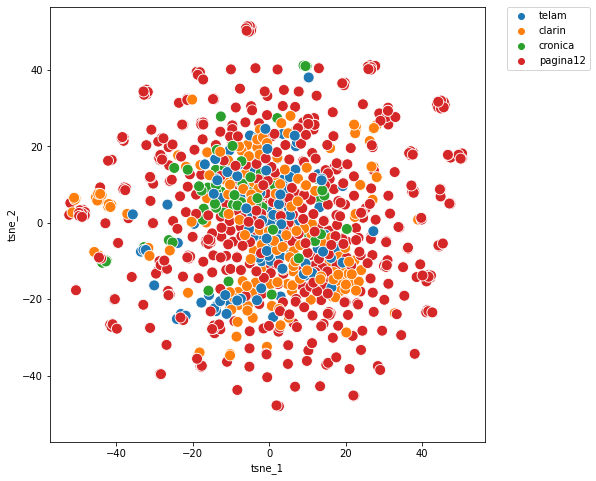

In [ ]:
n_components=2
# y=df[df['diario'].map(lambda x:x in ['clarin','cronica'])]['diario']
# X=pd.DataFrame(df[df['diario'].map(lambda x:x in ['clarin','cronica'])]['embeding_mean'].to_list())

y=df.sample(n=1000,random_state=1978)['_etiqueta_']
X=pd.DataFrame(df.sample(n=1000,random_state=1978)['embeding_mean'].to_list())

tsne=TSNE(n_components)
tsne_result=tsne.fit_transform(X)
tsne_result.shape

tsne_result_df=pd.DataFrame({'tsne_1':tsne_result[:,0] ,'tsne_2':tsne_result[:,1] ,'label':y})

# Grafica
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
sns.scatterplot(x='tsne_1',y='tsne_2',hue='label',data=tsne_result_df,ax=ax,s=120)
lim=(tsne_result.min()-5,tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)

##6.3 Clasification

### 6.3.1. Stemmer

In [ ]:
train, test = train_test_split(df_stemmer, random_state=42, test_size=0.20, shuffle=True)

Procesando Categoria: clarin
Best thr: 0.2180262373106064
AUC:0.9236941265106325
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1819
           1       0.67      0.79      0.73       521

    accuracy                           0.87      2340
   macro avg       0.80      0.84      0.82      2340
weighted avg       0.88      0.87      0.87      2340



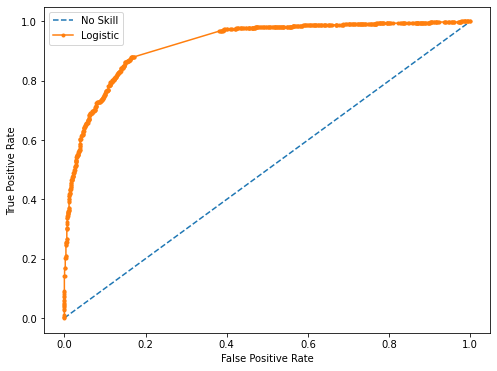

Procesando Categoria: cronica
Best thr: 0.14514506203315325
AUC:0.8998390837725077
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2208
           1       0.47      0.53      0.50       132

    accuracy                           0.94      2340
   macro avg       0.72      0.75      0.73      2340
weighted avg       0.94      0.94      0.94      2340



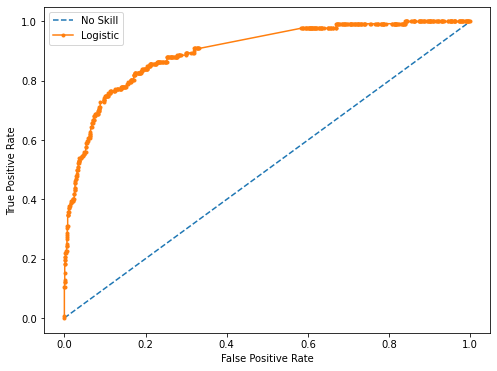

Procesando Categoria: pagina12
Best thr: 0.6
AUC:0.9371449393366815
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       884
           1       0.88      0.93      0.91      1456

    accuracy                           0.88      2340
   macro avg       0.88      0.86      0.87      2340
weighted avg       0.88      0.88      0.88      2340



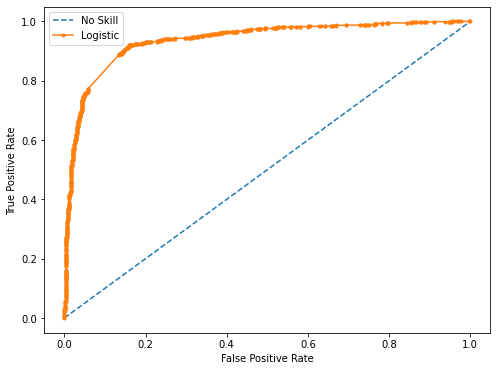

Procesando Categoria: telam
Best thr: 0.15384147807172766
AUC:0.9352732773785406
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2109
           1       0.54      0.71      0.62       231

    accuracy                           0.91      2340
   macro avg       0.75      0.82      0.78      2340
weighted avg       0.93      0.91      0.92      2340



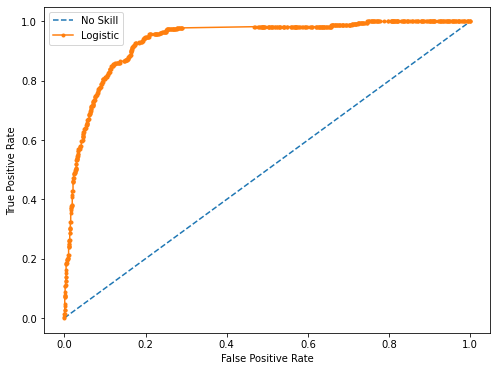

In [ ]:
# entrenamiento(train,'stem')
testeo(test,'stem')

### 6.3.2. TF-IDF Lemmatization

In [ ]:
train, test = train_test_split(df_lemma, random_state=42, test_size=0.20, shuffle=True)

Procesando Categoria: clarin
Best thr: 0.27225124230741665
AUC:0.9248036560131434
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1819
           1       0.73      0.72      0.73       521

    accuracy                           0.88      2340
   macro avg       0.83      0.82      0.82      2340
weighted avg       0.88      0.88      0.88      2340



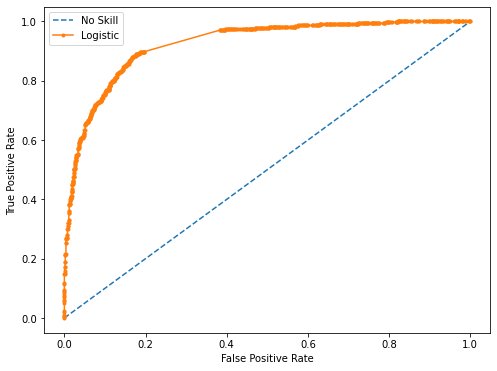

Procesando Categoria: cronica
Best thr: 0.24916914933942852
AUC:0.8727578090689504
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2208
           1       0.60      0.36      0.45       132

    accuracy                           0.95      2340
   macro avg       0.78      0.67      0.71      2340
weighted avg       0.94      0.95      0.94      2340



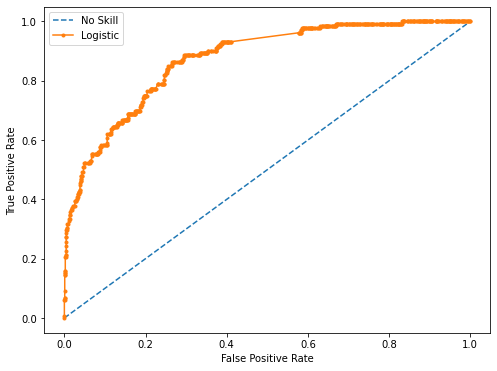

Procesando Categoria: pagina12
Best thr: 0.6
AUC:0.9438988613196757
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       884
           1       0.90      0.92      0.91      1456

    accuracy                           0.89      2340
   macro avg       0.88      0.87      0.88      2340
weighted avg       0.88      0.89      0.88      2340



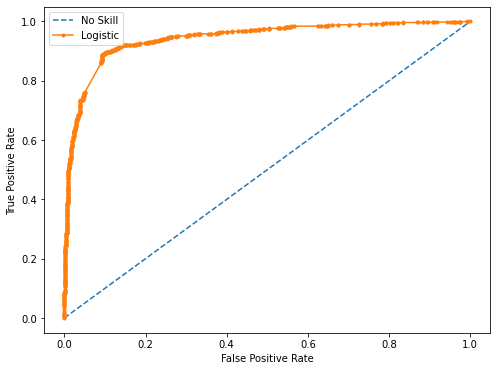

Procesando Categoria: telam
Best thr: 0.1838374632954212
AUC:0.9371432266169109
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2109
           1       0.56      0.71      0.62       231

    accuracy                           0.92      2340
   macro avg       0.76      0.82      0.79      2340
weighted avg       0.93      0.92      0.92      2340



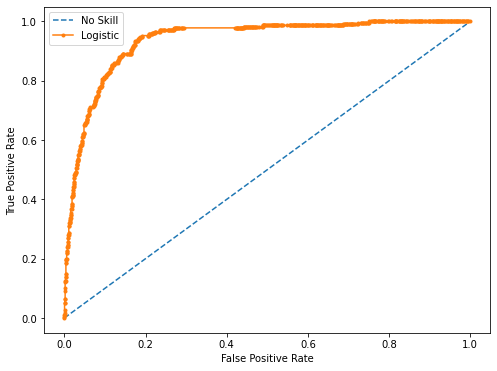

In [ ]:
# entrenamiento(train,'lema')
testeo(test,'lema')

### 6.3.3. Word2Vect

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.20, shuffle=True)

Procesando Categoria: clarin
Best thr: 0.21765784987601833
AUC:0.9588739415460257
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1904
           1       0.75      0.84      0.79       523

    accuracy                           0.91      2427
   macro avg       0.85      0.88      0.87      2427
weighted avg       0.91      0.91      0.91      2427



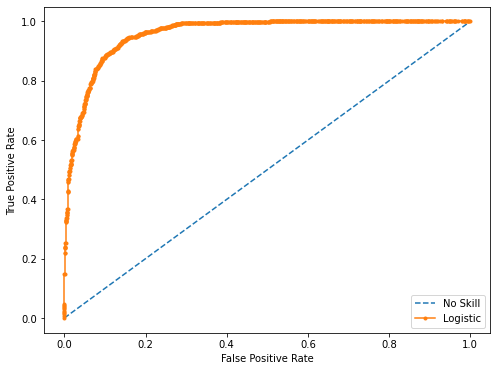

Procesando Categoria: cronica
Best thr: 0.12615194380403402
AUC:0.9377908589391931
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2285
           1       0.46      0.70      0.55       142

    accuracy                           0.93      2427
   macro avg       0.72      0.82      0.76      2427
weighted avg       0.95      0.93      0.94      2427



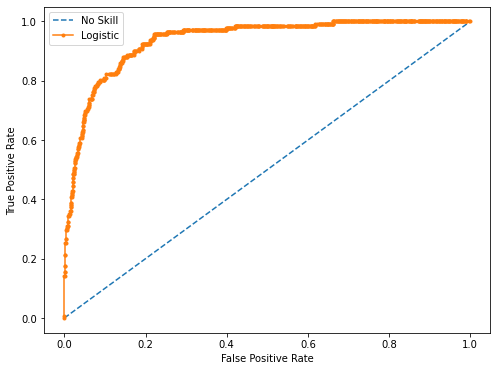

Procesando Categoria: pagina12
Best thr: 0.6
AUC:0.9961755390658605
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       961
           1       0.99      0.98      0.98      1466

    accuracy                           0.98      2427
   macro avg       0.98      0.98      0.98      2427
weighted avg       0.98      0.98      0.98      2427



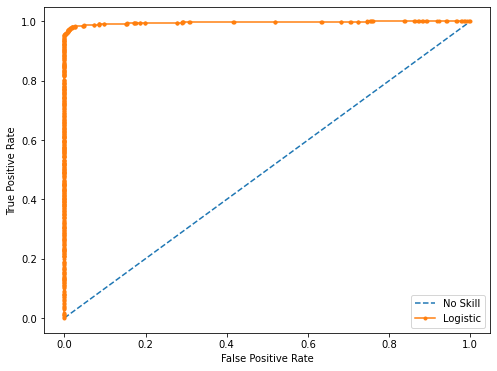

Procesando Categoria: telam
Best thr: 0.3125705376494035
AUC:0.9539376894491862
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2131
           1       0.67      0.77      0.71       296

    accuracy                           0.93      2427
   macro avg       0.82      0.86      0.84      2427
weighted avg       0.93      0.93      0.93      2427



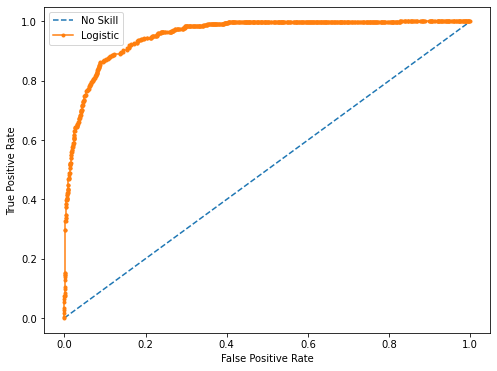

In [ ]:
# entrenamiento_w2v(train,'w2v')
testeo_w2v(test,'w2v')

<a id = "1.0"></a>
<p style="font-size:25px;color:#16268a;font-family:'Avantgarde';text-align:center;border-radius:5px;">
<strong>______________________________</strong></p> 

# 7. ANEXO - Análisis notas completas

In [ ]:
df_notas=pd.read_excel("full_notas_final.xlsx")
print("\nTamaño original:"+str(df_notas.shape))

# limpiamos columnas que no se van a usar
df_notas=df_notas.drop(['link', 'fecha','descripcion','titulo'], axis=1)

# Se eliminan duplicados
df_notas.drop_duplicates(inplace=True)
df_notas.reset_index(inplace=True)
print("Tamaño sin duplicados:"+str(df_notas.shape))


Tamaño original:(3085, 6)
Tamaño sin duplicados:(3053, 3)


In [ ]:
#Tokenizacion
df_notas['cont_tokens'] = df_notas['contenido'].apply(lambda x: word_tokenize(x, language='spanish'))

In [ ]:
import string

stopf = set(stopwords.words('spanish'))

print("'más' esta en stopword :"+str('más' in stopf))
print("'mas' esta en stopwor :"+str('mas' in stopf))
print("\nIMPORTANTE: Aquí se puede ver que la palabra sin acento no es encontrada \n\n")

# Por tal motivo se agregan las stop sin acentos
stopf = stopf.union(set([sw.translate(str.maketrans('áéíóúü','aeiouu')) for sw in stopf])) 
stopf.update(string.punctuation) # Agrega signos de puntuacion

def limpiezaf(texto):
  texto=texto.lower().strip()
  # Se limpian los caracteres especiales
  texto=re.sub(r"[^A-Za-z0-9áéíóúüÁÉÍÓÚÜ]+", "", texto)
  texto = re.sub('<.*?>', ' ', texto)
  texto = re.sub('\[.*?¿\]\%', ' ', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  

  #limpio los numeros sino quedan muchas fechas
  texto=re.sub(r"\d+", "", texto)
  return texto

df_notas['cont_stop']=df_notas['cont_tokens'].map(lambda x:[limpiezaf(word)for word in x if limpiezaf(word) not in (stopf)])
df_notas['cont_stop'].head()

'más' esta en stopword :True
'mas' esta en stopwor :False

IMPORTANTE: Aquí se puede ver que la palabra sin acento no es encontrada 




0    [audaz, declaración, oído, leído, final, guerr...
1    [mayra, mendoza, habló, lunes, imputación, cau...
2    [reunión, tensa, debate, cúpula, pro, , ex, pr...
3    [unión, ferroviaria, acordó, lunes, aumento, s...
4    [nueva, embestida, ministro, economía, martín,...
Name: cont_stop, dtype: object

In [ ]:
#Top words en notas completas
def get_top_n_words_notas(corpus, n=10):
    cv = CountVectorizer()
    corpus_matrix = cv.fit_transform(corpus)
    print(corpus_matrix.shape)
    corpus_matrix = pd.DataFrame.sparse.from_spmatrix(corpus_matrix, columns=cv.get_feature_names())
    aux = corpus_matrix.sum()
    aux=aux.to_frame('count')
    aux.sort_values(by='count',ascending=False,inplace=True)
    aux=aux.head(n)
    return aux

most_importantsn = get_top_n_words_notas(df_notas['cont_stop'].map(lambda x:' '.join([word for word in x])), n=500)
print(most_importantsn.head(10))
px.bar(most_importantsn, x=most_importantsn.index, y='count')

(3053, 62610)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                       count
oacute                 14244
div                    12236
class                   7510
iacute                  6921
dataindex               5994
adserverzonasnoticias   5994
aacute                  4819
nbsp                    2560
eacute                  2511
argentina               2433


In [ ]:
#eliminamos palabras que no tienen sentido
words_eliminar_nf = ['do','ldquo','rdquo','li','aos','ao','amp','cómo','','do','div','class','oacute','px','iacute','ntilde','dataindex','adserverzonasnoticias','aacute','eacute','strong','eacute','nbsp']
df_notas['cont_clear']=df_notas['cont_stop'].map(lambda x:[word for word in x if word not in (words_eliminar_nf)])

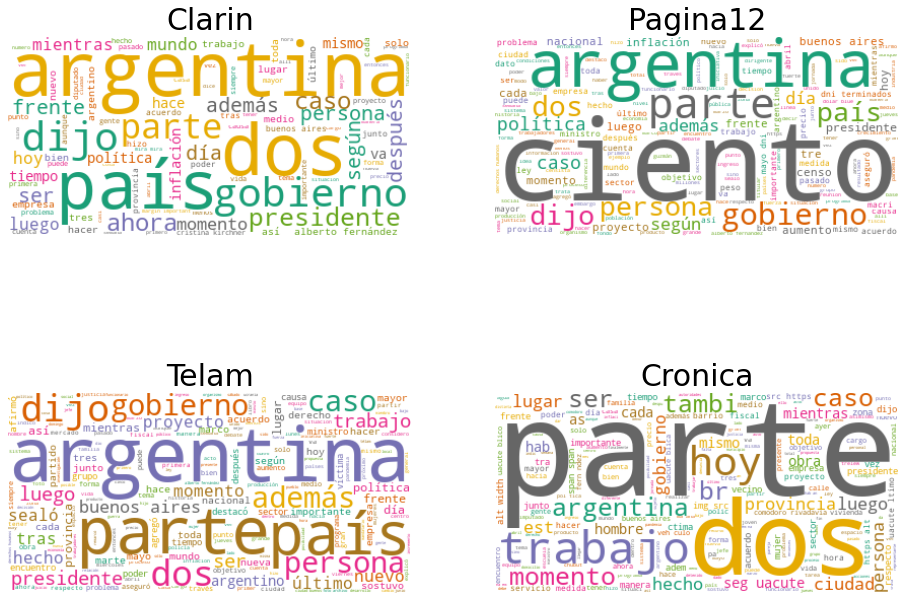

In [ ]:
#hacemos una nube de palabras
plt.rcParams['figure.figsize'] = [16,12]
from wordcloud import WordCloud
wc = WordCloud(stopwords=stopf, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


for index,diario in enumerate(df_notas['diario'].unique()):
  texto = " ".join(df_notas[df_notas['diario']==diario]['cont_clear'].map(lambda x:' '.join([word for word in x])))
  wc.generate(texto)
  plt.subplot(2, 2, index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.rcParams['figure.figsize'] = [16, 12]
  plt.axis('off')
  plt.title(diario, fontsize=30)

plt.show()

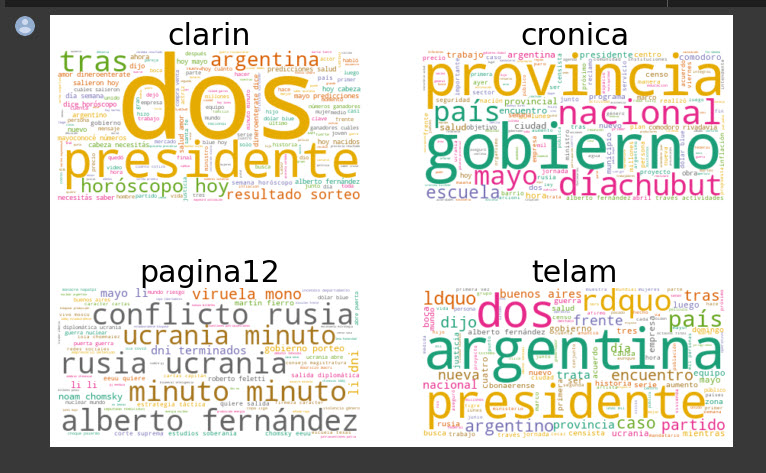

En comparacion con el dataset de titulos y descripciones, notamos que nube de palabras cambia bastante.


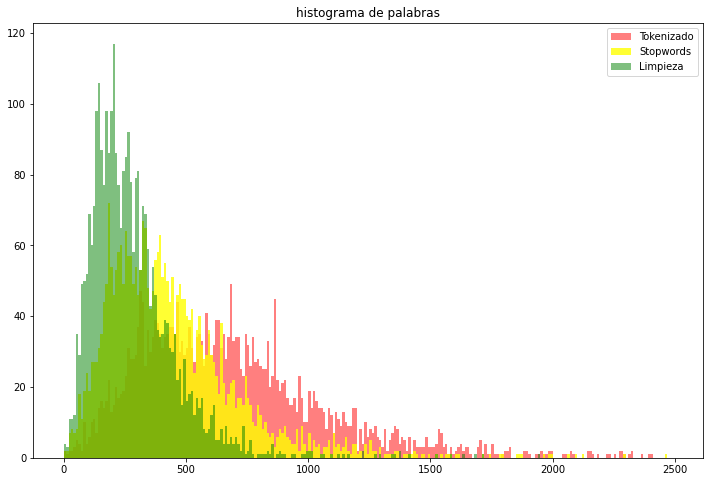

In [ ]:
#resultados
plt.rcParams['figure.figsize'] = [12, 8]

plt.hist(df_notas['cont_tokens'].str.len(),bins = np.arange(0,2500,10), color='red', alpha=0.5 )
plt.hist(df_notas['cont_stop'].str.len(),bins = np.arange(0,2500,10), color='yellow', alpha=0.8 )
plt.hist(df_notas['cont_clear'].str.len(),bins = np.arange(0,2500,10), color='green', alpha=0.5 )

plt.title("histograma de palabras")
plt.legend(['Tokenizado','Stopwords','Limpieza'])

In [ ]:
#Stemming de notas completas
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

def word_stemmer_fn(text):
    #Luego del stemmer se realiza la remocion de acentos
    stem_text = [PorterStemmer().stem(i).translate(str.maketrans('áéíóúü','aeiouu')) for i in text] 

    return stem_text

df_notas['cont_stemmer'] = df_notas['cont_clear'].map(lambda x: word_stemmer_fn(x))
df_notas['cont_stemmer'].head()

0    [audaz, declaracion, oido, leido, final, guerr...
1    [mayra, mendoza, hablo, lune, imputacion, caus...
2    [reunion, tensa, debat, cupula, pro, ex, presi...
3    [union, ferroviaria, acordo, lune, aumento, sa...
4    [nueva, embestida, ministro, economia, martin,...
Name: cont_stemmer, dtype: object

In [ ]:
#Lematizacion de notas completas
nlp = spacy.load("es_core_news_lg")

def word_lemmatizer_fn(text):
    #Luego de lemmatizar elimino los acentos
    lem_text = [token.lemma_.translate(str.maketrans('áéíóúü','aeiouu')) for token in nlp(" ".join(text))]
    return lem_text

df_notas['cont_lemma'] = df_notas['cont_clear'].apply(lambda x: word_lemmatizer_fn(x))
df_notas['cont_lemma'].head()

0    [audaz, declaracion, oido, leido, final, guerr...
1    [mayra, mendoza, hablar, lunes, imputacion, ca...
2    [reunion, tenso, debate, cupula, pro, ex, pres...
3    [union, ferroviario, acordar, lunes, aumento, ...
4    [nuevo, embestida, ministro, economia, martin,...
Name: cont_lemma, dtype: object

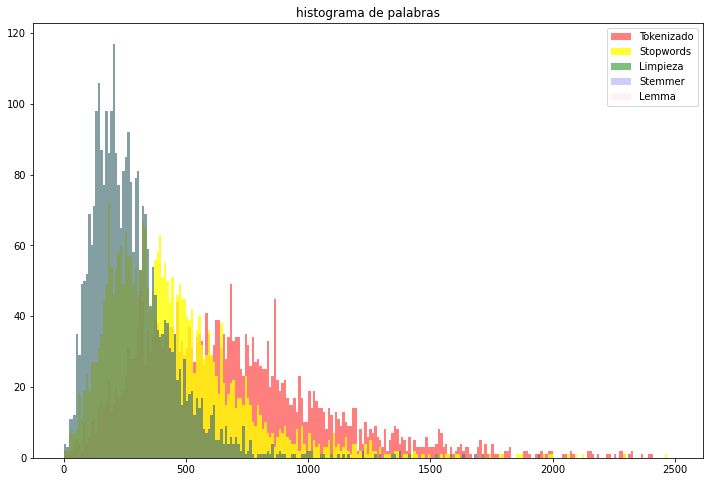

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

plt.hist(df_notas['cont_tokens'].str.len(),bins = np.arange(0,2500,10), color='red', alpha=0.5 )
plt.hist(df_notas['cont_stop'].str.len(),bins = np.arange(0,2500,10), color='yellow', alpha=0.8 )
plt.hist(df_notas['cont_clear'].str.len(),bins = np.arange(0,2500,10), color='green', alpha=0.5 )
plt.hist(df_notas['cont_stemmer'].str.len(),bins = np.arange(0,2500,10), color='blue', alpha=0.2 )
plt.hist(df_notas['cont_lemma'].str.len(),bins = np.arange(0,2500,10), color='pink', alpha=0.2 )

plt.title("histograma de palabras")
plt.legend(['Tokenizado','Stopwords','Limpieza','Stemmer','Lemma'])